# AI for Materials Workshop
## Tutorial on Graph Neural Networks for Materials Science

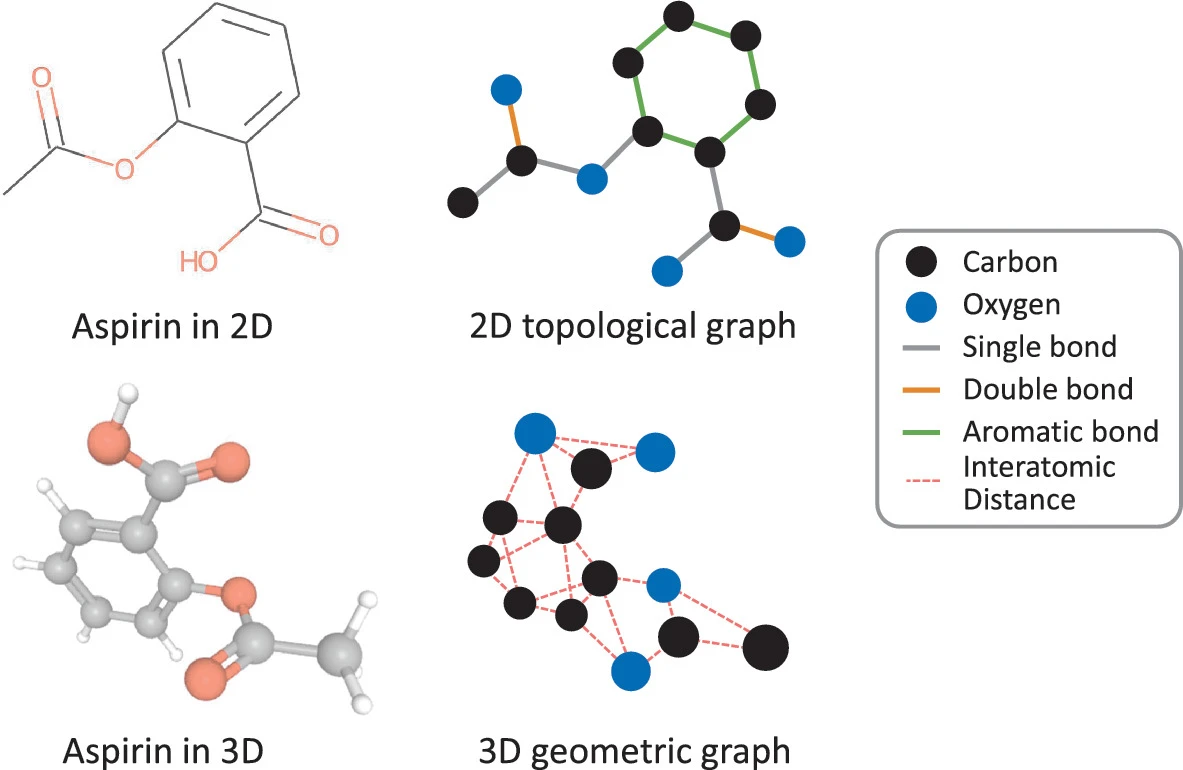

*Image source: [Graph Neural Networks for Molecules](https://link.springer.com/chapter/10.1007/978-3-031-37196-7_2/figures/2)*

**Authors:**
Jama Hussein Mohamud.

**Introduction:**

Welcome to this tutorial on Graph Neural Networks (GNNs) for Materials!

GNNs have gained significant attention in research and industry due to their ability to model complex relationships in data. In material science, many problems naturally take the form of graphs—where atoms are nodes, bonds are edges, and interactions can be captured using structured learning methods.

In this tutorial, we will:
- Understand the theory behind graphs and GNNs
- Understand the basics of PyTorch Geometric (PyG)
  - Installing and setting up PyG.
  - Basic operations with toy datasets (e.g. Cora).
- Data Loading and Manipulation in PyG
 - Understanding Data and DataLoader in PyG.
- Implementing GNN Models with PyG (e.g. GCNs and/or GATs)
- Applications on Cora and Materials Datasets
- Intro on how to create a Custom Graph Dataset, i.e. convert your own dataset into a PyG-compatible graph format.

**Prerequisites:**

- Some familiarity with PyTorch (we will be using `PyTorch Geometric`)
- Neural network basics
- Graph theory basics (MIT Open Courseware [slides](https://ocw.mit.edu/courses/1-022-introduction-to-network-models-fall-2018/resources/mit1_022f18_lec2/) by Amir Ajorlou)

We recommend watching the [Theoretical Foundations of Graph Neural Networks Lecture](https://www.youtube.com/watch?v=uF53xsT7mjc&) by Petar Veličković before attending the practical. The talk provides a theoretical introduction to Graph Neural Networks (GNNs), historical context, and motivating examples.

**Follow-up Work:**
If you found this interesting, we recommend this [course](https://web.stanford.edu/class/cs224w/) which covers GNNs in depth.

## Setting Up
Run the following cells to install the necessary packages.

In [1]:
%%capture
!pip install torch_geometric
!pip install networkx
!pip install mp-api
# dielectric graph data download (we will use this data later)
!gdown 'https://drive.google.com/uc?id=1r9Wb5Ci9JJsbeU3NYBfd93VCP_8Z4_o7'

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Imports

import torch
import random
import numpy as np
import networkx as nx
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from mp_api.client import MPRester
from torch_geometric.data import Data
import torch_geometric.transforms as T
from emmet.core.summary import HasProps
from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import Planetoid
from pymatgen.core.periodic_table import Element
from pymatgen.analysis.local_env import CrystalNN
from sklearn.model_selection import train_test_split
from torch_geometric.nn import GCNConv, global_mean_pool

In [4]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Call the function to set the seed
set_seed(42)

## Introduction

Graphs are a powerful and flexible representation of data, widely used in various fields such as social networks, knowledge graphs, and recommendation systems. However, one of their most impactful applications is in scientific domains, particularly in molecular and materials modeling.

In materials science, crystals, molecules, and compounds naturally lend themselves to a graph representation, where:

- Nodes represent atoms
- Edges represent bonds or interactions between atoms

For example, consider the structure of a bulk organic crystal:
- The arrangement of atoms within the crystal defines its electronic, mechanical, and thermal properties.
- Using Graph Neural Networks (GNNs), we can learn patterns in these structures to predict properties such as band gaps, conductivity, or stability, etc.


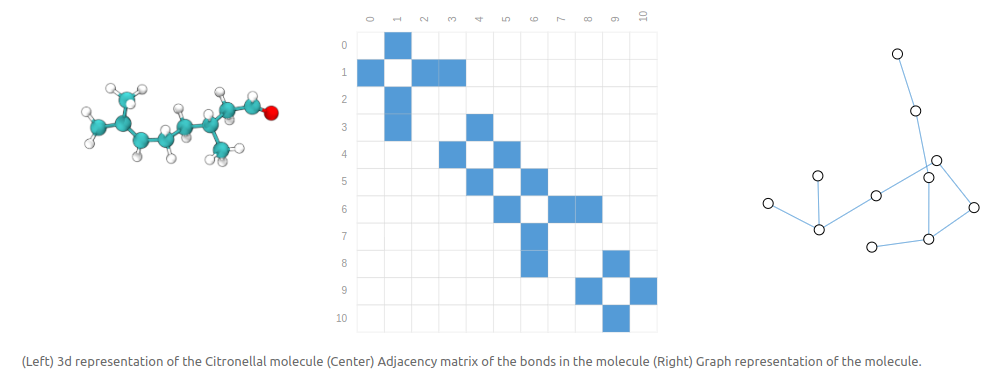


*Image source: [A Gentle Introduction to Graph Neural Networks](https://distill.pub/2021/gnn-intro/)*

This example illustrates a powerful aspect of graphs: the structure of a molecule (or material) is explicitly encoded into the graph representation itself. Each atom is a node, and each bond is an edge, allowing us to capture complex interactions.

Graph-based representations enable a variety of scientific applications. For example:

- In chemistry, graphs are widely used in drug discovery to model molecular interactions and predict binding affinity.
- In materials science, graphs can represent bulk crystal structures, allowing us to predict properties like electrical conductivity, band gaps, and stability.
- In physics, graphs are useful for modeling atomic lattices, fluid networks, and energy transfer systems.

Graphs also appear in unexpected places:

- Images can be modeled as graphs, where each pixel is a node connected to its neighbors, forming a structured grid.
- Citation networks represent research papers as nodes, with edges representing citations between them.

Now that we understand how graphs naturally arise in scientific problems, let's go over some graph theory basics before diving into Graph Neural Networks (GNNs).

## Section 1: Graphs and Networks

### Recap of Graph Fundamentals

A **graph** is a pair $ G = (V, E) $, where:

- $V$ is the set of $ N $ **vertices (nodes)**.
- $E$ is the set of **edges (links)**, i.e., pairs $ (u,v) $ representing a connection between two nodes $ u,v \in V $.

There are several ways to represent $ E $:

1. **Edge list**: A list of pairs $ (u,v) $, where each pair represents an edge between node $ u $ and node $ v $.
2. **Adjacency matrix**: A binary square matrix $ A $ of size $ |V| \times |V| $, where $ A_{u,v} = 1 $ if there is an edge between nodes $ u $ and $ v $.
3. **Adjacency list**: An array of $ |V| $ unordered lists, where the $ i $-th list corresponds to node $ i $ and contains all nodes directly connected to it.

Example: Below is a directed graph with four nodes and five edges.

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/toy_graph.png" width="400px">

The arrows on the edges indicate the direction of each edge, e.g. there is an edge going from node 0 to node 1. Between node 0 and node 3, there are two edges: one going from node 0 to node 3 and one from node 3 to node 0.

Node 0 has out-degree of 2, since it has two outgoing edges, and an in-degree of 2, since it has two incoming edges.

The list of edges is:
$$[(0, 1), (0, 3), (1, 2), (2, 0), (3, 0)]$$

As adjacency matrix:

$$\begin{array}{l|llll}
 source \setminus dest    & n_0 & n_1 & n_2 & n_3 \\ \hline
n_0 & 0    & 1    & 0    & 1    \\
n_1 & 0    & 0    & 1    & 0    \\
n_2 & 1    & 0    & 0    & 0    \\
n_3 & 1    & 0    & 0    & 0
\end{array}$$

As adjacency list:

$$[\{1, 3\}, \{2\}, \{0\}, \{0\}]$$



Graph G with 5 nodes and 5 edges
Adjacency list: [(0, 2), (0, 4), (0, 5), (4, 5), (5, 6)]
Adjacency matrix (symmetric):
[[0 1 1 1 0]
 [1 0 0 0 0]
 [1 0 0 1 0]
 [1 0 1 0 1]
 [0 0 0 1 0]]
Degree of node 0: 3


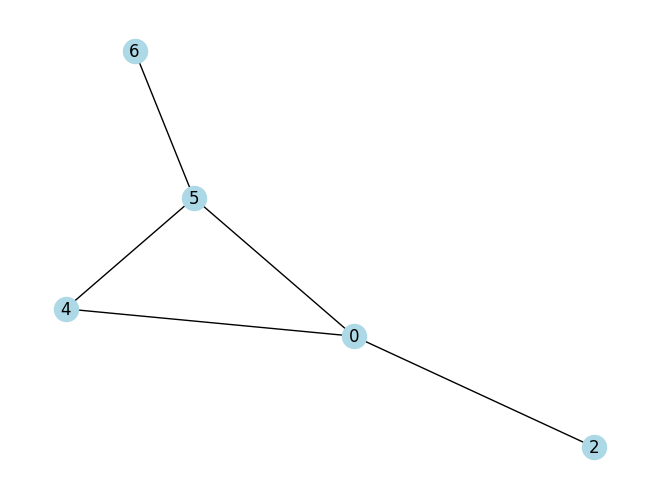

In [5]:
# Create a simple graph
G = nx.Graph() # Use DiGraph for directed graphs

G.add_nodes_from([0, 2, 4, 5, 6]) # Fill in the list of node labels as integers
G.add_edges_from([(0, 2), (0, 4), (4, 5), (5, 6), (0, 5)]) # Fill in the list of node pairs [(node_a, node_b)]
# Note that for a NetworkX (undirected) Graph, you do not need to provide both (node_a, node_b) and (node_b, node_a)

# Print basic info
nb_nodes = G.number_of_nodes()
nb_edges = G.number_of_edges()
print(f'Graph G with {nb_nodes} nodes and {nb_edges} edges')
print(f'Adjacency list: {G.edges}')
print(f'Adjacency matrix (symmetric):')
A = nx.adjacency_matrix(G) # Returns a sparse matrix
print(A.todense())
print(f'Degree of node 0: {G.degree(0)}')

# Draw the graph
nx.draw(G, with_labels=True, node_color='lightblue')

## Section 2: Intro to the PyTorch Geometric Library

PyTorch Geometric (PyG) is a framework for deep learning on graphs and other irregular structures, built on PyTorch.


#### PyG Data Object
PyG uses a Data object to represent graphs efficiently. A typical graph dataset in PyG consists of:

- `data.x`: Node feature matrix [num_nodes,num_features]
- `data.edge_index`: Graph connectivity (list of edges)
- `data.edge_attr`: Optional edge features [num_edges,num_edge_features]
- `data.y`: Labels if using supervised learning
- `data.pos`: Optional node positions (for spatial graphs)

Let's create a simple toy graph:

In [6]:
# Define the edges (source -> target)
edge_index = torch.tensor([
    [0, 1, 1, 2],  # From nodes
    [1, 0, 2, 1]   # To nodes
], dtype=torch.long)

# Define node features (each node has 1 feature)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

# Create PyG Data object
data = Data(x=x, edge_index=edge_index)

print(data)  # Print the Data object structure
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Feature shape: {data.x.shape}")


Data(x=[3, 1], edge_index=[2, 4])
Number of nodes: 3
Number of edges: 4
Feature shape: torch.Size([3, 1])


PyG has a lot of toy common Benchmark Datasets
Let us load the Cora dataset for instance. The Cora dataset is a citation network where:

- Nodes represent research papers
- Edges represent citations
- Features are word embeddings of each paper

In [7]:
# Load Cora dataset
dataset = Planetoid(root="./data", name="Cora")

# Get the first (and only) graph in the dataset
data = dataset[0]

print(f"Dataset: {dataset}")
print(f"Graph object: {data}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Feature matrix shape: {data.x.shape}")
print(f"Number of classes: {dataset.num_classes}")

Processing...


Dataset: Cora()
Graph object: Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Feature matrix shape: torch.Size([2708, 1433])
Number of classes: 7


Done!


There are 2708 nodes, and each has a 1433-dimensional feature vector (word embeddings). The graph has 10,556 edges and 7 possible classes. train_mask, val_mask, test_mask represent boolean masks to separate training, validation, and test nodes.

Let us plot a subgraph of the Cora dataset using networkx. We will pick random node and find a connected subgraph.

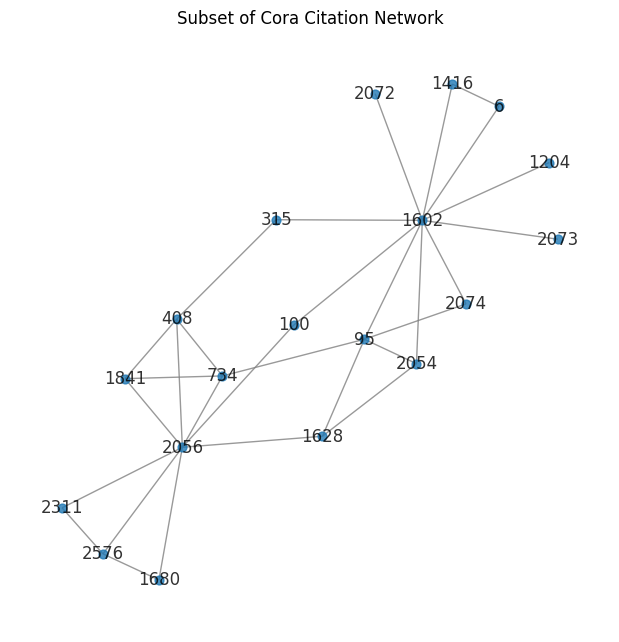

In [8]:
# Convert PyG data to NetworkX graph (undirected for better visualization)
G = to_networkx(data, to_undirected=True)

# Pick a random node and find a connected subgraph
start_node = 100  # Choose a node (can be randomized)
subset_nodes = list(nx.single_source_shortest_path_length(G, start_node, cutoff=2).keys())  # Get nodes within 2-hop neighborhood
G_sub = G.subgraph(subset_nodes)  # Extract the subgraph

# Plot the small subset
plt.figure(figsize=(6, 6))
nx.draw(G_sub, node_size=40, edge_color="gray", alpha=0.8, with_labels=True)
plt.title("Subset of Cora Citation Network")
plt.show()

#### PyG Mini-Batching

In PyG, mini-batching is essential for training large datasets. Since graphs have different structures, PyG uses batching tricks to stack multiple graphs into a single tensor.

PyG DataLoader handles mini-batching and also supports a lot of other basic features like shuffling.  

In [9]:
# Create a dataset with multiple copies of the Cora graph (for batching)
dataset_list = [dataset[0] for _ in range(4)]  # Simulate 4 small graphs

# Create a DataLoader for batching
loader = DataLoader(dataset_list, batch_size=2, shuffle=True)

# Fetch one batch
for batch in loader:
    print(batch)
    print(f"Batch num_nodes: {batch.num_nodes}")  # Total nodes in batch
    print(f"Batch num_edges: {batch.num_edges}")  # Total edges in batch
    print(f"Batch has edge index: {batch.edge_index.shape}")  # Edge shape
    break  # Only print the first batch


DataBatch(x=[5416, 1433], edge_index=[2, 21112], y=[5416], train_mask=[5416], val_mask=[5416], test_mask=[5416], batch=[5416], ptr=[3])
Batch num_nodes: 5416
Batch num_edges: 21112
Batch has edge index: torch.Size([2, 21112])


`batch` is a column vector which maps each node to its respective graph in the batch.

#### PyG Data Transforms

Just like image transformations in `torchvision`, PyG provides data transforms to modify graphs before using them in a model. These transforms can:
- Normalize features
- Add self-loops
- Convert graphs to different formats
- Apply augmentations for data augmentation

PyG supports two types of transformations:
- `pre_transform`: Applied once before saving the dataset to disk.
- `transform`: Applied dynamically every time a graph is loaded.


In many GNN architectures (like GCNs), adding self-loops can improve information flow. PyG provides a simple transform for this:

In [10]:
# Load Cora dataset with a self-loop transform
dataset = Planetoid(root="./data", name="Cora", transform=T.AddSelfLoops())

# Get the transformed graph
data = dataset[0]

# Print edge count before and after adding self-loops
print(f"Number of edges after adding self-loops: {data.num_edges}")
print(f"Does the graph have self-loops? {data.has_self_loops()}")

Number of edges after adding self-loops: 13264
Does the graph have self-loops? True


## Section 3: Graph Neural Network Theory

A GNN is a neural network designed to work on graph data. We start with an initial representation of our problem in the form of a graph. In the figure below, you can see an example of such a graph. The diagram illustrates new important aspects of graph neural networks:
- Each node has an initial vector representation (grey box associated with each node)
- Node are connected by different edge types (represented by different coloured arrows).

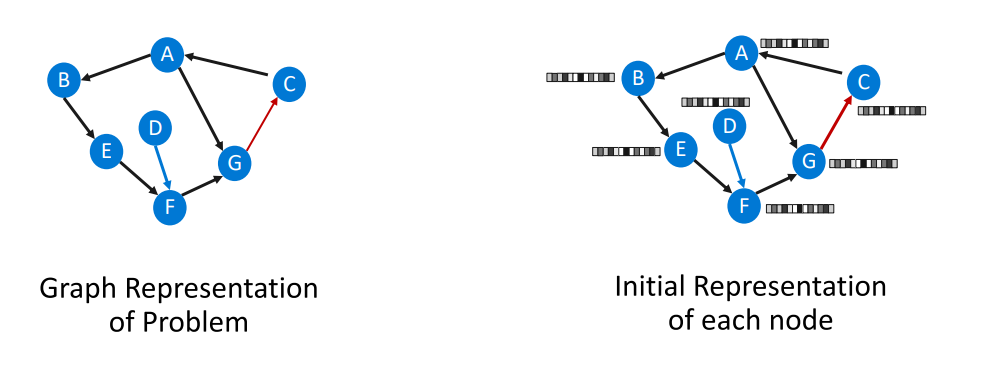

*Image Source: [An Introduction to Graph Neural Networks: Models and Application ](https://www.youtube.com/watch?v=zCEYiCxrL_0&t=824s)*

The GNN updates these node representations during training, outputting task-specific output representations. An overview of this process is illustrated below:

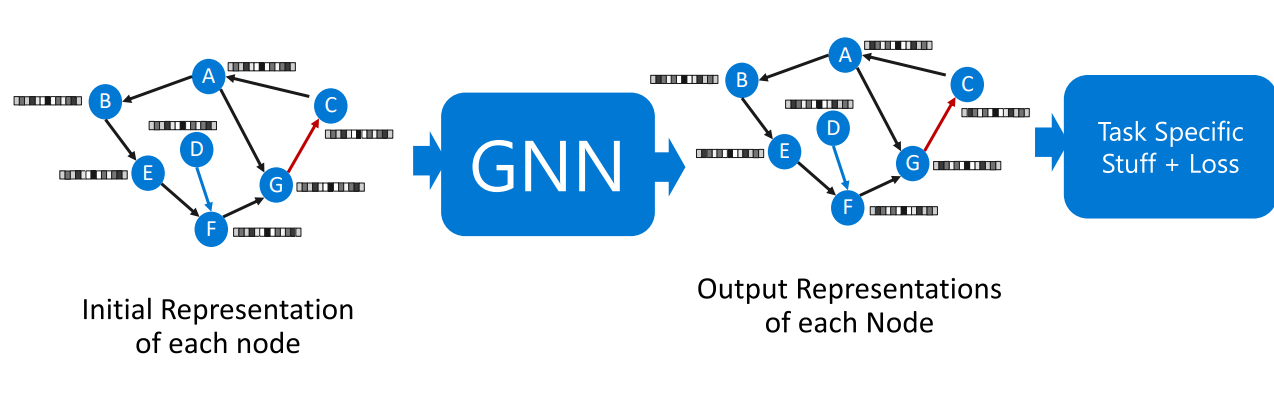


*Image Source: [An Introduction to Graph Neural Networks: Models and Application ](https://www.youtube.com/watch?v=zCEYiCxrL_0&t=824s)*

Neural Message Passing is a popular framework to perform this update. In a nutshell, each node representation is updated by exchanging information with the neighbouring nodes. To examine the node update in detail, let's consider a smaller neighbourhood of the graph such as nodes D, E and F pictured below.

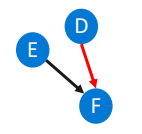

To update the vector representation of node F, we consider the following:

- Current vector representation of node F
- Vector representations of all nodes connected to F (e.g. E and D).
- Edge types of connected nodes.  

For each neighbour node (e.g. E and D) we compute a 'message' using some function $f$, which takes in the adjacent node representation and edge type as input. The output of function $f$ is the message vector. There are a vareity of different functions we could use to prepare this message and we'll go into some concrete examples later in the tutorial.

The messages from all the adjacent nodes are then summarized and used to update the current node state. The diagram below illustrates this process, whereby the vector representation of node F at time $t$ is labelled as $h^{n}_{t-1}$.

The notation is as follows:
- $t$ = timestep
- $h$ = node vector representation
- $k$ = edge type
- $f$ = function which prepares a message
- $⋃$ = function which summarised the messages
- $q$ = node update function

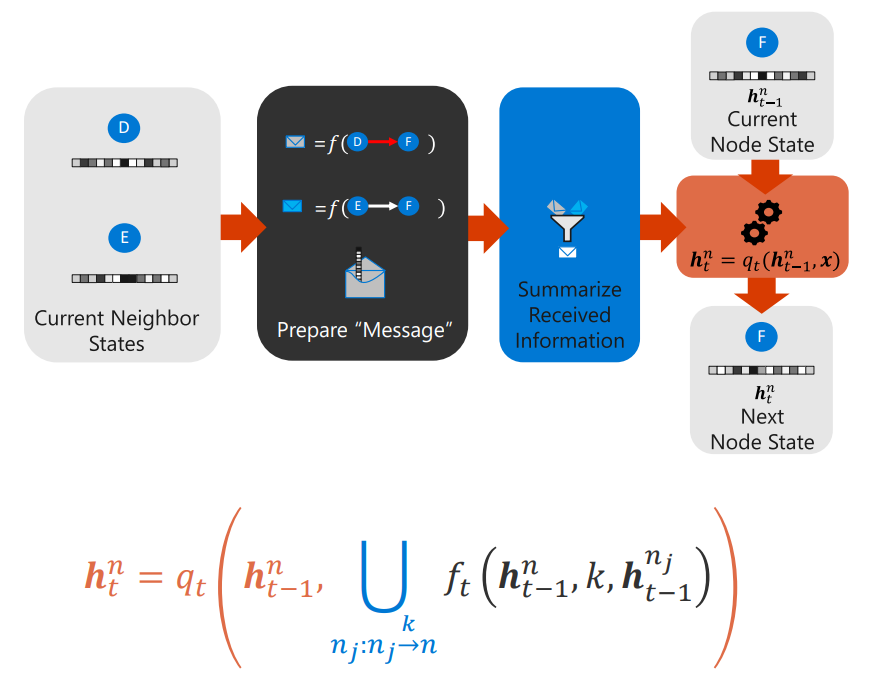

*Image Source: [An Introduction to Graph Neural Networks: Models and Application ](https://www.youtube.com/watch?v=zCEYiCxrL_0&t=824s)*

The equation at the bottom of the image is coloured coded to match the step in the diagram. For example, black represents the function to prepare the message, blue the function to summarise these messages and orange to update the node step.

Note that $⋃$ must be permutation invariant, as the messages are not ordered.

### Graph Prediction Tasks
What are the kinds of problems we want to solve on graphs?


The tasks fall into roughly three categories:

1. **Node Classification**: E.g. what is the topic of a paper given a citation network of papers?
2. **Link Prediction / Edge Classification**: E.g. are two people in a social network friends?
3. **Graph Classification**: E.g. is this protein molecule (represented as a graph) likely going to be effective?

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/graph_tasks.png" width="700px">

*The three main graph learning tasks. Image source: Petar Veličković.*

Which examples of graph prediction tasks come to your mind? Which task types do they correspond to?


## Section 4: Updating Node Features Locally

The high-level perspective on the way GNNs are applied:



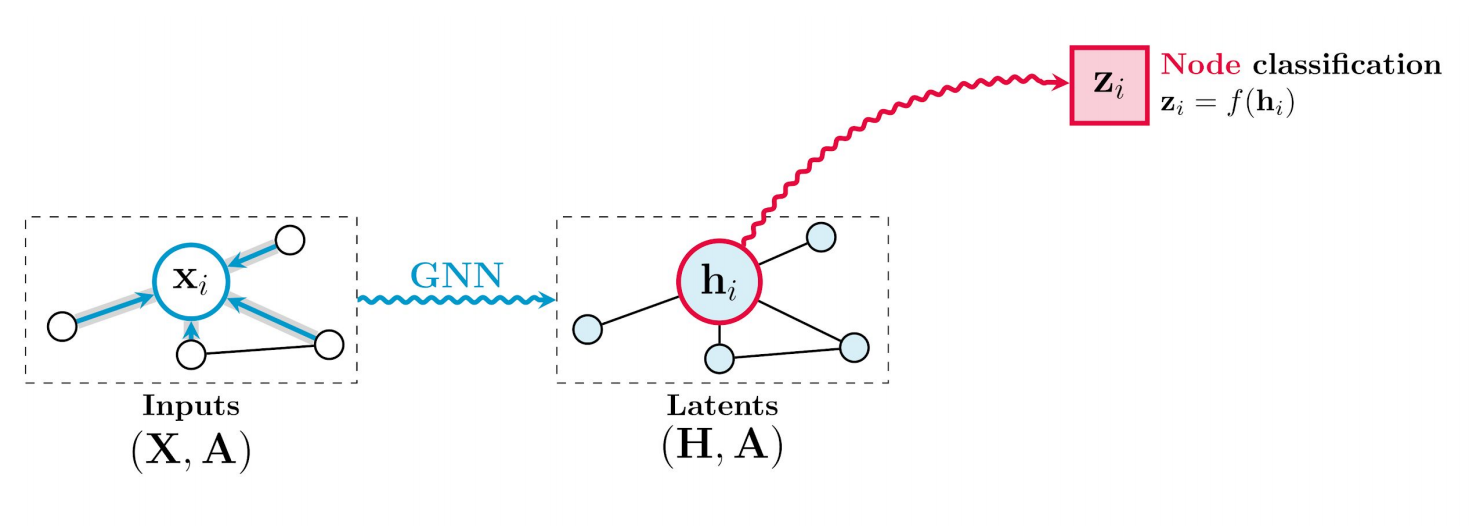

We start from a graph with adjacency matrix $A$ and node features $x_i$. Using a GNN, for each node we compute (based on its neighborhood) a latent feature vector $h_i$, by *aggregating* node features from adjacent nodes. With these latent vectors we can attempt to solve various tasks, where for now we focus on **node classification**.

In node classification, we are most often given a single graph, where only a portion of nodes is labeled. Using these nodes as a signal for training, our goal is to successfully classify the remaining nodes. To this end, we look at previously computed node latent vectors in isolation, and learn a classifier $z_i = f(h_i)$.




## Section 5: Implementing Graph Neural Networks (GNNs)

We'll start by implementing a Graph Convolutional Network (GCN), one of the most fundamental GNN architectures. The GCN model extends standard neural networks to graph-structured data by aggregating information from neighboring nodes.

Given the adjacency matrix A of size $N \times N$ (where N is the number of nodes), and the node feature matrix $H$ of size $N \times F$ (where each node has an $F$-dimensional feature vector), the mean-pooling propagation rule is defined as:

$$ H' = \sigma(D^{-1}AHW^T) $$
Where,
- $W$ is a learnable weight matrix of shape $F' \times F$.
- $D$ is the diagonal degree matrices, where $D_{ii} = \sum_jA_{ij}$ (the degree of node $i$).
- $\sigma(\cdot)$ is a non-linear activation function (e.g. ReLU).
- H' represents the updated node features with shape  ($N \times F'$).

Focusing on a single node $i$, we get the following equation for its updated features:

$$ h'_i = \sigma \left( \frac{1}{|N(i)|}\sum_{j \in N(i)}  Wh_j \right) $$

where $N(i)$ denotes the set of neighbors of node $i$.

This means that each node updates its features by averaging the transformed features of its neighbors.

#### Adding Symmetric Normalization

Notice that nodes can have different degrees (i.e., different numbers of neighbors). This could lead to training instabilities, such as exploding or vanishing gradients. To mitigate this, we introduce normalization by node degrees.

A simple approach is normalize $AH$ by dividing it by the node degrees:

$${D}^{-1}AH$$

However, this approach only considers outgoing degrees and may still introduce bias. Instead, we use symmetric normalization, as proposed by Kipf & Welling in their [paper](https://arxiv.org/abs/1609.02907):

$$D^{-\frac{1}{2}}AD^{-\frac{1}{2}}H$$

This adjusts for both incoming and outgoing degrees, ensuring balanced information aggregation across the graph.

Thus, our final update rule becomes:

$$ H' = \sigma(D^{-\frac{1}{2}}AD^{-\frac{1}{2}}HW^T) $$

### Implementing a Simple GCN Model in PyG

We'll define a simple two-layer GCN using PyG's GCNConv module.

In [11]:
# Define a simple 2-layer GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)  # First GCN layer
        self.conv2 = GCNConv(hidden_channels, out_channels)  # Second GCN layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)  # Apply non-linearity
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)  # Log-softmax for classification

In [12]:
# Load Cora dataset
dataset = Planetoid(root="./data", name="Cora")

# Initialize model
model = GCN(in_channels=dataset.num_features, hidden_channels=16, out_channels=dataset.num_classes)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


### Training the GCN Model

Now, we train the GCN on the Cora dataset.

In [13]:
# Define optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = dataset[0].to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])  # Negative log-likelihood loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for 200 epochs
for epoch in range(200):
    loss = train()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.4f}")


Epoch 0: Loss = 1.9481
Epoch 20: Loss = 0.0882
Epoch 40: Loss = 0.0133
Epoch 60: Loss = 0.0138
Epoch 80: Loss = 0.0160
Epoch 100: Loss = 0.0148
Epoch 120: Loss = 0.0132
Epoch 140: Loss = 0.0120
Epoch 160: Loss = 0.0111
Epoch 180: Loss = 0.0104


### Evaluating the Model

We now evaluate the model's performance on the test set.

In [14]:
def test():
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)  # Get predicted class
        correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
        acc = int(correct) / int(data.test_mask.sum())
        print(f"Test Accuracy: {(acc * 100):.2f}%")

test()

Test Accuracy: 80.30%


~80% accuracy on Cora is expected for a standard 2-layer GCN. If you want to push accuracy higher, you can experiment with the different hyper-params and play with the model capacity.

## Section 6: Creating a Custom Materials Dataset

In this section, we will explore how to convert real-world materials science data into a graph-based format suitable for Graph Neural Networks (GNNs). Using the Materials Project API, we will fetch dielectric property data, extract atomic structures, and represent them as graph-based inputs where:

- Nodes represent atoms with features such as atomic number, mass, atomic_mass, melting point, electronegativity, etc.
- Edges represent bond strength and distances.
- Graph targets correspond to the dielectric constant.

With this dataset will train a GCN model to predict dielectric constants.

#### Downloading Materials Data from the Materials Project API

In this step, we retrieve materials data from the Materials Project API. Specifically, we fetch 600 materials that have recorded dielectric properties. Each material includes:

- A unique material ID (e.g., mp-149 for silicon).
- The crystal structure (atomic positions, lattice, and connectivity).
- The dielectric constant, which measures how a material interacts with electric fields.

Since not everyone in the tutorial will have API access, we pre-saved the dataset, so this step is only for explanation. Instead of calling the API live, we will directly load the stored data later.

In [15]:
API_KEY = "YOUR-API-KEY"

with MPRester(API_KEY) as mpr:
    # Fetch only the first 100 materials with dielectric data
    docs = mpr.materials.summary.search(
        has_props=[HasProps.dielectric], # Filter materials that have dielectric data
        fields=["material_id", "structure", "n"],
        chunk_size=100,  # Fetch 100 at a time
        num_chunks=6  # Limit total to 600 materials (6 x 100)
    )

    data = [
        {
            "material_id": doc.material_id,
            "structure": doc.structure,
            "dielectric": doc.n
        }
        for doc in docs
    ]

print(f"Fetched {len(data)} materials")

Retrieving SummaryDoc documents:   0%|          | 0/600 [00:00<?, ?it/s]

Fetched 600 materials


#### Converting Materials Data into Graphs

This section converts crystal structures into graph representations, which are used as inputs for Graph Neural Networks (GNNs). The goal is to transform materials data into a graph format where atoms are nodes, and bonds (atomic interactions) are edges.

##### Extracting Atomic Features

The function `get_atomic_features(specie)` extracts physical and chemical properties of each atom, such as:

- Atomic number, mass, ionization energy, and radii.
- Periodic table properties: Group, period, metal type (e.g., transition metal, alkali, halogen, noble gas).

In [16]:
def get_atomic_features(specie):
    """
    Extract atomic features for a given element.

    Args:
        specie (pymatgen Element): Atomic species from pymatgen.

    Returns:
        list: Feature vector containing atomic properties.
    """
    element = Element(specie.symbol)

    return [
        element.number,                    # Atomic Number
        element.atomic_mass,                # Atomic Mass
        element.ionization_energy or 0,     # Ionization Energy
        element.van_der_waals_radius or 0,  # Van der Waals Radius (alternative to covalent radius)
        element.melting_point or 0,         # Melting Point
        element.boiling_point or 0,         # Boiling Point
        element.row,                        # Period in periodic table
        element.group,                      # Group in periodic table
        int(element.is_metal),              # 1 if Metal, 0 otherwise
        int(element.is_transition_metal),   # 1 if Transition Metal, 0 otherwise
        int(element.is_alkali),             # 1 if Alkali Metal, 0 otherwise
        int(element.is_alkaline),           # 1 if Alkaline Earth Metal, 0 otherwise
        int(element.is_halogen),            # 1 if Halogen, 0 otherwise
        int(element.is_noble_gas)           # 1 if Noble Gas, 0 otherwise
    ]

#### Building the Graph

The function convert_structure_to_graph(structure, dielectric) constructs a graph representation:

1. Nodes (Atoms): Each atom in the crystal structure becomes a node with extracted features.
2. Edges (Bonds): Atoms are connected based on their neighboring relationships, using CrystalNN.
 - Each edge stores information like bond strength and interatomic distance.
3. Target (Dielectric Constant): The dielectric constant is the label (y-value) for supervised learning. Since dielectric constant is a continues value, the task becomes regression.

In [17]:
def convert_structure_to_graph(structure, dielectric):
    """
    Convert a material's crystal structure into a PyTorch Geometric graph.

    Args:
        structure (pymatgen.Structure): Crystal structure from Materials Project.
        dielectric (float): Target dielectric constant.

    Returns:
        PyG Data object representing the material's graph.
    """

    # Step 1: Define Node Features (Atoms)
    node_features = torch.tensor(
        [get_atomic_features(site.specie) for site in structure], dtype=torch.float
    )  # Shape: [num_nodes, num_features]

    # Step 2: Define Edges (Bonds)
    edge_index = []
    edge_attr = []

    # Use CrystalNN to determine neighbors (alternative: structure.get_neighbors())
    crystal_nn = CrystalNN()
    for i, site in enumerate(structure):
        neighbors = crystal_nn.get_nn_info(structure, i)

        for neighbor in neighbors:
            j = neighbor['site_index']  # Neighbor atom index
            weight = neighbor['weight']  # Bond strength or distance
            distance = np.linalg.norm(site.coords - neighbor['site'].coords)  # Compute Euclidean distance

            edge_index.append([i, j])
            edge_attr.append([weight, distance])

    # Convert to tensors
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()  # Shape: [2, num_edges]
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)  # Shape: [num_edges, 1]

    # Step 3: Define Target (Dielectric Constant)
    y = torch.tensor([dielectric], dtype=torch.float)  # Shape: [1]

    # Step 4: Create PyG Data Object
    graph_data = Data(
        x=node_features,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=y
    )

    return graph_data

In [18]:
# Convert entire dataset
graph_dataset = []
for i, sample in enumerate(data):
    material_id = sample["material_id"]
    structure = sample["structure"]
    dielectric = sample["dielectric"]

    if i % 50 == 0:
      print(f"Processing {i} = {material_id}...")

    try:
        graph = convert_structure_to_graph(structure, dielectric)
        graph_dataset.append(graph)
    except Exception as e:
        print(f"Skipping i: {i}, material_id: {material_id} due to error: {e}")

print(f"Converted {len(graph_dataset)} materials into graphs.")

Processing 0 = mp-570778...
Processing 50 = mp-752826...
Processing 100 = mp-25469...
Processing 150 = mp-569175...
Processing 200 = mp-27148...
Processing 250 = mp-11342...
Processing 300 = mp-1591...
Processing 350 = mp-942...
Processing 400 = mp-1105223...
Processing 450 = mp-669426...
Processing 500 = mp-7868...
Processing 550 = mp-556961...
Converted 600 materials into graphs.


In [19]:
# Save dataset as a PyTorch file
torch.save(graph_dataset, "dielectric_graph_dataset.pt")

print("Dataset saved successfully!")

Dataset saved successfully!


In [20]:
# Load dataset

graph_dataset = torch.load("dielectric_graph_dataset.pt")

In [21]:
graph_dataset[0]

Data(x=[16, 14], edge_index=[2, 16], edge_attr=[16, 2], y=[1])

We now split the data into train and test splits.

In [22]:
# Define train/test split (80% train, 20% test)
train_data, test_data = train_test_split(graph_dataset, test_size=0.2, random_state=42)

# Create PyG DataLoaders
batch_size = 32  # You can adjust this based on available memory

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_data)}, Test size: {len(test_data)}")

Train size: 480, Test size: 120


#### Graph Neural Network (GNN) Model for Regression

This class defines a Graph Convolutional Network (GCN) for regression, designed to predict the dielectric constant of materials. Unlike classification models that predict discrete labels, this model outputs a continuous value.

The model consists two more components compared to previous GCN model:

1. Graph-Level Representation (`global_mean_pool`):
This operation aggregates the learned node representations into a single vector per graph using global mean pooling.

2. Fully Connected Layer (fc):

Maps the graph-level representation to a single scalar output (i.e., predicted dielectric constant).

In [23]:
class GCNRegressor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(GCNRegressor, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, 1)  # Single output for regression

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Aggregate graph-level representation
        x = global_mean_pool(x, batch)

        # Output single scalar per graph (dielectric constant)
        return self.fc(x).squeeze()  # Shape: [batch_size]


In [24]:
# Model Init
model = GCNRegressor(in_channels=graph_dataset[0].x.shape[1], hidden_channels=16).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = torch.nn.MSELoss()  # Mean Squared Error for regression

# Training loop
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)  # Predicted dielectric constant
        loss = loss_fn(out, data.y)  # MSE Loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Train for 200 epochs
for epoch in range(200):
    loss = train()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.4f}")


Epoch 0: Loss = 5114.7597
Epoch 20: Loss = 102.8597
Epoch 40: Loss = 102.4069
Epoch 60: Loss = 99.6405
Epoch 80: Loss = 98.2519
Epoch 100: Loss = 99.1453
Epoch 120: Loss = 97.4036
Epoch 140: Loss = 96.8943
Epoch 160: Loss = 96.3366
Epoch 180: Loss = 96.3626


In [25]:
# Testing function
def test():
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            loss = loss_fn(out, data.y)
            total_loss += loss.item()
    print(f"Test MSE: {total_loss / len(test_loader):.4f}")

# Run test
test()

Test MSE: 5.1551


Change the learning rate to 0.1. What happens to the  MSE?

### Section 7: Take-Home Assignment

1.  In this tutorial, we used a GCN-based model that only considers node features for predicting the dielectric constant of materials. However, edges in a graph (representing atomic bonds) also contain valuable information—such as bond strength and distances—which could help improve the model.
  - Explore PyTorch Geometric (PyG) documentation to find GNN layers that support edge attributes
  - Replace GCNConv in the GCNRegressor with a suitable PyG message-passing layer that supports `edge_attr`.
  - Train the new model on the same dataset and compare performance (e.g., test MSE).

2. So far, we have worked with a relatively small dataset that can be easily stored in a .pt file and loaded into memory. However, in real-world applications, materials datasets can be massive, containing thousands or even millions of crystal structures.

  In such cases, it is not practical to store everything in memory at once. Instead, we need to:
  - Store data efficiently using `HDF5, LMDB, Parquet, or SQLite` databases instead of `.pt` files.

  - Load data dynamically by implementing a custom PyG Dataset class that fetches data only when needed (on-the-fly loading).

Therefore, do the following:

- Research efficient data storage formats (`HDF5, LMDB, Parquet, hugginface`)
- Implement a PyG Dataset class, i.e. create a custom PyTorch Geometric Dataset that dynamically loads data from the stored file.


## Conclusion

In this practical session, we explored Graph Neural Networks (GNNs) and how they can be applied to various tasks including citation and material networks. For example, predicting the dielectric properties of materials. 

To further deepen your understanding of GNNs and their applications, we recommend the following resources and references:

**References:**
 - [CS224W: Machine Learning with Graphs](https://web.stanford.edu/class/cs224w/)
 - [Geometric Deep Learing](https://geometricdeeplearning.com/lectures/)
 - [Theoretical Foundations of Graph Neural Networks Lecture](https://www.youtube.com/watch?v=uF53xsT7mjc&)


 **Credits:**
 - [Intro to graphnets tutorial with jraph](https://github.com/google-deepmind/educational/blob/master/colabs/summer_schools/intro_to_graph_nets_tutorial_with_jraph.ipynb)
 - [Deep Learning Indaba 2022 GNN Practical](https://github.com/deep-learning-indaba/indaba-pracs-2022/blob/main/practicals/GNN_practical.ipynb)